<a href="https://colab.research.google.com/github/chiangtinhung-rgb/Matcha/blob/main/HW4_%E6%96%87%E5%AD%97%E8%B3%87%E6%96%99%E5%B0%8F%E5%88%86%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HW4-文字資料自動化分析與智慧洞察生成**


#### **一、 專案摘要 **

本專案旨在建立一個從試算表（Sheet）讀取文字資料、進行自動化文字探勘（Text Mining），並利用大型語言模型（LLM）生成深度洞察的整合式解決方案。目標是將大量的開放式回答數據，快速轉化為結構化的統計報表與可付諸行動的智慧型摘要，以高效地掌握數據背後的關鍵趨勢與使用者聲音。

---

#### **二、 核心目標與執行步驟 **

| 階段 | 原始目標 | 修飾與深化描述 |
| :--- | :--- | :--- |
| **1. 資料擷取與輸入** | 從 Sheet 讀開放式回答 | **自動化資料擷取 (Automated Data Retrieval)**：透過 API 或連線機制，從指定試算表（例如 Google Sheet）讀取所有開放式回答欄位的原始文字資料。 |
| **2. 文字分析與處理** | 做詞數與關鍵字計數 | **文字探勘與特徵提取 (Text Mining & Feature Extraction)**：執行基礎的**詞頻統計 (Word Count)**，並應用如 **TF-IDF (Term Frequency-Inverse Document Frequency)** 等進階技術，進行**關鍵字/熱詞提取**，以識別最具代表性與區分度的核心詞彙。 |
| **3. 結果輸出與彙整** | 輸出前 N 熱詞 | **關鍵發現產出 (Key Finding Output)**：根據權重或頻率，輸出並視覺化呈現**前 N 個最熱門/最具代表性的關鍵詞**及其統計數據。 |
| **4. 報告回寫** | 回寫統計表 | **數據回饋與報表自動化 (Data Writeback & Reporting Automation)**：將完整的詞彙統計、關鍵字列表與權重分析結果，自動回寫或新增至試算表分頁中，形成即時統計報表。 |

---

#### **三、 AI 賦能加值 **

利用大型語言模型（LLM）的語義理解與生成能力，為數據分析結果賦予智慧化的解讀與摘要，實現專案的最終價值：

1.  **智慧洞察摘要 (Smart Insight Summaries):**
    * **產出五個精闢的洞察摘要（5 Key Insights）**：模型將基於熱詞分佈、詞彙權重與原始文本內容，提煉出五個核心的趨勢判斷、使用者情緒或數據亮點，以供決策參考。
2.  **結論與行動建議 (Conclusion and Actionable Recommendations):**
    * **生成一段約 120 字的精簡結論 (Concise 120-word Conclusion)**：對整體分析結果進行高效的總結，並可包含初步的行動建議或未來研究方向。



#### **四、分析結果(試驗參考)**

# 1.分析頁面
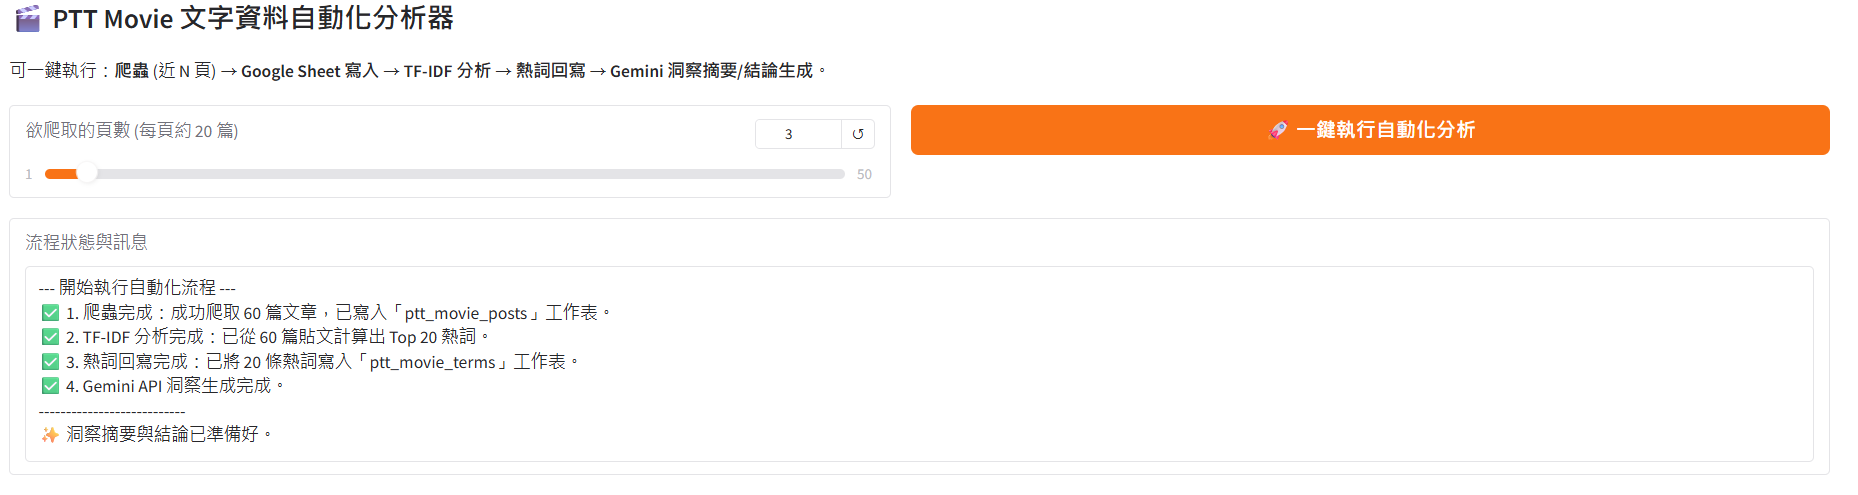

# 2.爬蟲分析結果(以3頁為例)

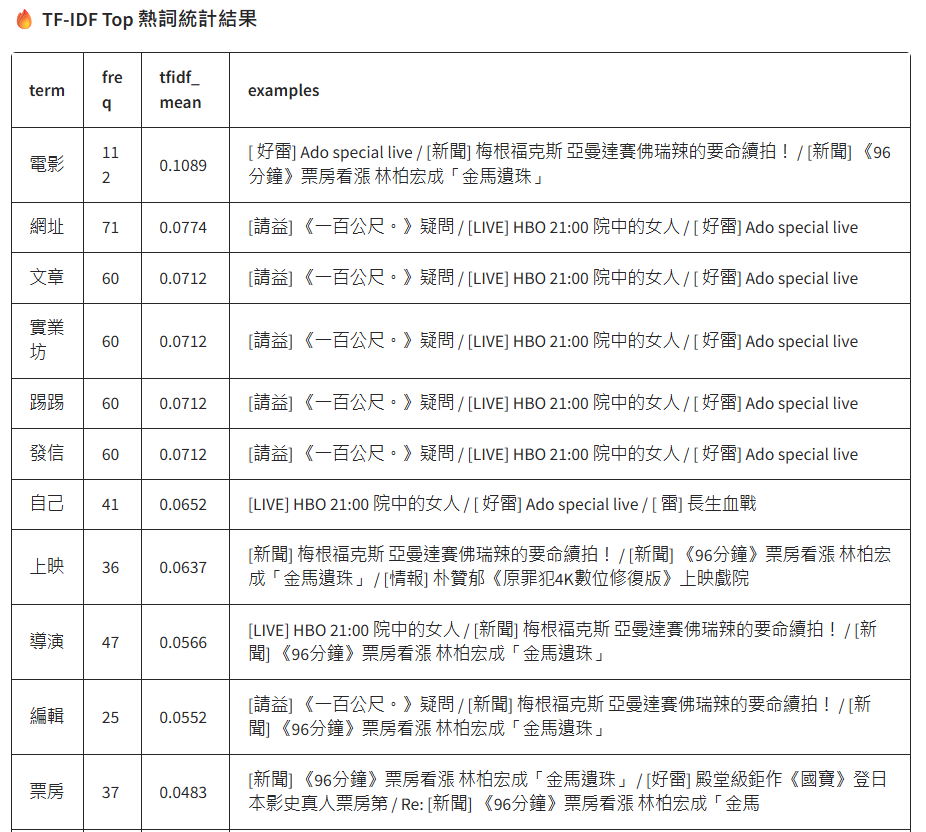



# 3.AI分析結果(以三頁為例)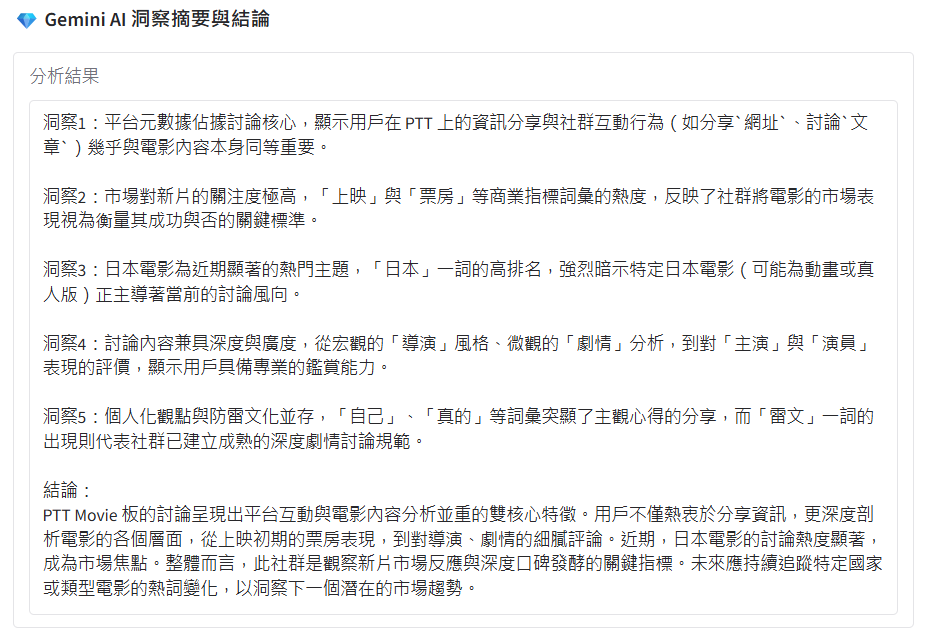

#### **五、程式碼**

In [ ]:
import requests
from bs4 import BeautifulSoup

In [ ]:
!pip -q install gspread gspread_dataframe google-auth google-auth-oauthlib google-auth-httplib2 \
               gradio pandas beautifulsoup4 google-generativeai python-dateutil

In [ ]:
# 新增 TF-IDF 相關套件
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
import numpy as np

In [ ]:
import os, time, uuid, re, json, datetime
from datetime import datetime as dt, timedelta
from dateutil.tz import gettz
import pandas as pd
import gradio as gr
import requests
from bs4 import BeautifulSoup

import google.generativeai as genai

# Google Auth & Sheets
from google.colab import auth
import gspread
from gspread_dataframe import set_with_dataframe, get_as_dataframe
from google.auth.transport.requests import Request
from google.oauth2 import service_account
from google.auth import default

In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [ ]:
from google.colab import userdata

# 從 Colab Secrets 中獲取 API 金鑰
api_key = userdata.get('MATCHA')

# 使用獲取的金鑰配置 genai
genai.configure(api_key=api_key)

model = genai.GenerativeModel('gemini-2.5-pro')

In [ ]:
SHEET_URL = "https://docs.google.com/spreadsheets/d/1qR5tsLMzL1tVHRQvkg3gHrznzEWlVGIunhS-I7m9rzU/edit?usp=sharing"
WORKSHEET_NAME = "工作表1"
TIMEZONE = "Asia/Taipe"

In [ ]:
PTT_HEADER = [
    "post_id","title","url","date","author","nrec","created_at",
    "fetched_at","content"
]
TERMS_HEADER = ["term","freq","df_count","tfidf_mean","examples"]

In [ ]:
def ensure_spreadsheet(name):
    try:
        sh = gc.open(name)  # returns gspread.models.Spreadsheet
    except gspread.SpreadsheetNotFound:
        sh = gc.create(name)
    return sh

sh = ensure_spreadsheet(WORKSHEET_NAME)

In [ ]:
def ensure_worksheet(sh, title, header):
    try:
        ws = sh.worksheet(title)
    except gspread.WorksheetNotFound:
        ws = sh.add_worksheet(title=title, rows="1000", cols=str(len(header)+5))
        ws.update([header])
    # 若沒有表頭就補上
    data = ws.get_all_values()
    if not data or (data and data[0] != header):
        ws.clear()
        ws.update([header])
    return ws

In [ ]:
ws_ptt_posts = ensure_worksheet(sh, "ptt_movie_posts", PTT_HEADER)
ws_ptt_terms = ensure_worksheet(sh, "ptt_movie_terms", TERMS_HEADER)

In [ ]:
articles_data = []

In [ ]:
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

In [ ]:
def get_previous_page_url(soup):
    """獲取上一頁 (更新、更舊的文章) 的連結"""
    # PTT 的「上一頁」按鈕 HTML 結構：div class="btn-group btn-group-paging"
    paging_div = soup.find('div', class_='btn-group btn-group-paging')
    if paging_div:
        # PTT 頁面按鈕順序：最舊 (0), 上頁 (1), 下頁 (2), 最新 (3)
        # 我們要找的是「上一頁」 (即更舊的文章) 的連結，索引為 1
        prev_button = paging_div.find_all('a')[1]

        # 檢查連結是否有效 (如果已經是第一頁，連結會是 '#' 或沒有 href)
        if 'href' in prev_button.attrs:
            return "https://www.ptt.cc" + prev_button['href']
    return None

In [ ]:
responseIndex = requests.get("https://www.ptt.cc/bbs/movie/index.html", headers=headers, timeout=5)
html_contentIndex = responseIndex.text
soupIndex = BeautifulSoup(html_contentIndex, 'html.parser')

In [ ]:
current_url = get_previous_page_url(soupIndex)

In [ ]:
current_url

In [ ]:
import re

def extract_index_split(url):
    """
    使用字串分割方法解析頁碼。

    邏輯：
    1. 以 'index' 分割網址：['...', '10808.html']
    2. 取第二個元素 ('10808.html')
    3. 以 '.html' 分割：['10808', '']
    4. 取第一個元素 ('10808')
    5. 轉換為整數
    """
    try:
        # 確保網址中包含 'index' 和 '.html'
        index_str = url.split('index')[1].split('.html')[0]
        return int(index_str)
    except IndexError:
        print("錯誤: 網址結構不符合預期 (缺少 'index' 或 '.html')")
        return None
    except ValueError:
        print("錯誤: 提取到的內容無法轉換為數字")
        return None

In [ ]:
# 指定的起始頁碼
START_INDEX = extract_index_split(current_url)
# 想要取得的頁數
PAGES_TO_FETCH = 10

# PTT 基礎網址
BASE_URL = "https://www.ptt.cc/bbs/movie/index"

# 計算迴圈的結束點 (例如: 10808 - 10 + 1 = 10799)
# range(start, stop, step) 的 stop 是不包含的，所以我們設為 START_INDEX - PAGES_TO_FETCH
stop_index = START_INDEX - PAGES_TO_FETCH

print(f"--- 正在生成從 {START_INDEX} 到 {stop_index + 1} 的 {PAGES_TO_FETCH} 個網址 ---")

# 使用 range 迴圈，從 START_INDEX 遞減到 stop_index
for index in range(START_INDEX, stop_index, -1):
    # 組合完整的 URL
    url = f"{BASE_URL}{index}.html"
    print(url)
    response = requests.get(url, headers=headers, timeout=5)
    html_content = response.text
    soup = BeautifulSoup(html_content, 'html.parser')
    article_list = soup.find_all('div', class_='r-ent')
    for article in article_list:
        # 標題 (Title) 和 連結 (Href) 資訊通常在 div class="title" 內
        title_tag = article.find('div', class_='title').find('a')

        # 排除被刪除或不可存取(標題為 - )的文章
        if title_tag:
            title = title_tag.text.strip()
            href = "https://www.ptt.cc" + title_tag['href']
        else:
            # 處理被刪除的文章 (通常標題會是 '-')
            title = article.find('div', class_='title').text.strip()
            href = "N/A (已刪除或不可存取)"

        # 作者 (Author) 資訊在 div class="author" 內
        author = article.find('div', class_='author').text.strip()

        # 日期 (Date) 資訊在 div class="date" 內
        date = article.find('div', class_='date').text.strip()

        # 儲存資料
        articles_data.append({
            'title': title,
            'date': date,
            'author': author,
            'href': href
        })

        # 額外要求：如果標題是指定標題，印出其對應的 href
        # 假設我們指定要特別關注標題包含 "新聞" 的文章
        # if '新聞' in title:
        #     print(f"[特別關注] 標題：{title} | 連結：{href}")
    # 註釋: 在實際的爬蟲程式中，您會將這個 url 傳遞給 requests.get() 函式來獲取內容
    # 例如: html_content = requests.get(url, headers=headers, cookies=cookies).text

In [ ]:
articles_data

In [ ]:
sentence = articles_data[1]['title']

In [ ]:
import jieba

# 待分詞的中文句子
print(f"原始句子: {sentence}\n")
print("-" * 40)

# --- 1. 精確模式 (Default Mode) ---
# 這是最常用的模式，嘗試將句子最精確地切開，適合文本分析。
print("模式一：精確模式 (jieba.cut)")
# jieba.cut 返回的是一個迭代器 (iterator)
seg_list_precise = jieba.cut(sentence, cut_all=False)
# 使用 '/ ' 將結果串接起來，方便輸出
print(f"分詞結果: {'/ '.join(seg_list_precise)}")
print("-" * 40)


# --- 2. 全模式 (Full Mode) ---
# 會掃描出句子中所有可能的詞語，速度最快，但結果可能有大量重疊。
print("模式二：全模式 (jieba.cut(..., cut_all=True))")
seg_list_all = jieba.cut(sentence, cut_all=True)
print(f"分詞結果: {'/ '.join(seg_list_all)}")
print("-" * 40)


# --- 3. 搜尋引擎模式 (Search Engine Mode) ---
# 在精確模式的基礎上，對長詞再次進行細分，適合用於搜尋引擎建立索引。
print("模式三：搜尋引擎模式 (jieba.cut_for_search)")
seg_list_search = jieba.cut_for_search(sentence)
print(f"分詞結果: {'/ '.join(seg_list_search)}")
print("-" * 40)


# --- 4. 詞性標註 (Optional: Add Part-of-Speech Tagging) ---
# jieba.posseg 可以在分詞的同時標註詞性 (例如 n: 名詞, v: 動詞)
import jieba.posseg as pseg
print("模式四：分詞與詞性標註 (jieba.posseg)")
words = pseg.cut(sentence)
result = []
for word, flag in words:
    result.append(f"{word}/{flag}")

print(f"分詞結果: {' '.join(result)}")
print("-" * 40)


In [ ]:
from collections import Counter

# 1. 初始化一個 Counter 物件來記錄所有單詞的頻率
word_counts = Counter()

# 2. 設定一個範圍，從索引 1 到 10 (包含)
# 在 Python 的 range 中，range(start, stop) 是從 start 到 stop-1
for i in range(1, 11):
    # 確保索引 i 存在，避免錯誤
    if i < len(articles_data) and 'title' in articles_data[i]:
        # 取出標題內容
        title_text = articles_data[i]['title']

        # --- 文本清理步驟 (重要) ---
        # 清除標點符號、空格、換行符等非中文字符
        # 使用正則表達式，保留中文、英文字母、數字
        cleaned_text = re.sub(r'[^\w\s]', '', title_text) # 移除大部分標點符號

        # 進行結巴分詞 (使用精確模式 jieba.cut)
        # cut() 返回的是一個 generator，通常會轉成 list
        # 或直接在迴圈中使用，這裡我們直接用來更新 Counter
        words = jieba.cut(cleaned_text, cut_all=False)

        # 將分詞結果更新到 word_counts
        # Counter 的 update() 方法可以直接接收一個可疊代對象（如 words）
        word_counts.update(words)

# 3. 清理分詞結果，移除空格、單個字母等常見雜訊
# 建立一個新的 Counter，只包含長度大於 1 的詞，或您認為有意義的詞
final_word_counts = Counter()
for word, count in word_counts.items():
    # 移除空字符串、空格、換行符
    if word.strip() and len(word.strip()) > 1:
        final_word_counts[word] = count

# 4. 輸出詞頻結果 (例如，前 10 個高頻詞)
print("--- 詞頻統計結果 (前 10 名) ---")
for word, count in final_word_counts.most_common(10):
    print(f"'{word}': {count} 次")

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict

# 設置一個簡單的停用詞列表（Stop Words）
# 這些詞通常頻率很高，但對文章主題貢獻小
stopwords = set(['的', '了', '是', '在', '我', '你', '他', '她', '之', '一個', '和', '討論', '分享'])

In [ ]:
document_list = []

# 從索引 1 到 10 (包含)
for i in range(1, 11):
    if i < len(articles_data) and 'title' in articles_data[i]:
        title_text = articles_data[i]['title']

        # 文本清理：移除標點符號和非詞語字符
        cleaned_text = re.sub(r'[^\w\s]', '', title_text)

        # 進行結巴分詞
        # lcut() 直接返回一個列表
        words = jieba.lcut(cleaned_text, cut_all=False)

        # 過濾停用詞和單個空白詞，並用空格重新連接成一個字符串，以便 TfidfVectorizer 處理
        filtered_words = [
            word.strip()
            for word in words
            if word.strip() and len(word.strip()) > 1 and word.strip() not in stopwords
        ]

        # TfidfVectorizer 需要的是字串形式的文檔
        document = " ".join(filtered_words)
        document_list.append(document)

# document_list 現在是一個列表，每個元素是經過處理的標題字串
# print(document_list)

In [ ]:
# 1. 初始化 TfidfVectorizer
# TfidfVectorizer 會處理：
#    a. 將文檔轉換為詞頻矩陣 (CountVectorizer 的工作)
#    b. 計算 TF-IDF 權重 (TfidfTransformer 的工作)
vectorizer = TfidfVectorizer()

# 2. 進行擬合和轉換 (Fit and Transform)
# tfidf_matrix 是一個稀疏矩陣 (sparse matrix)，包含所有文檔的 TF-IDF 權重
tfidf_matrix = vectorizer.fit_transform(document_list)

# 3. 獲取所有詞彙 (特徵名稱)
feature_names = vectorizer.get_feature_names_out()

# 4. 將稀疏矩陣轉換為 NumPy 陣列，方便查看權重
tfidf_array = tfidf_matrix.toarray()

In [ ]:
# 創建一個字典來存儲每個詞彙及其在所有文檔中的 TF-IDF 平均權重
avg_tfidf_scores = defaultdict(float)

# 遍歷所有文檔的權重
for doc_weights in tfidf_array:
    # 遍歷單篇文檔中的所有詞彙及其權重
    for i, weight in enumerate(doc_weights):
        word = feature_names[i]
        avg_tfidf_scores[word] += weight

# 計算平均值
num_documents = len(document_list)
for word in avg_tfidf_scores:
    avg_tfidf_scores[word] /= num_documents

# 按權重降序排列
sorted_avg_tfidf = sorted(avg_tfidf_scores.items(), key=lambda item: item[1], reverse=True)

print("--- 整個文檔集合中詞彙的 TF-IDF 平均權重 (前 10 名) ---")
for word, avg_weight in sorted_avg_tfidf[:10]:
    print(f"'{word}': {avg_weight:.4f}")

In [ ]:
# ==============
# PTT 電影版爬蟲
# ==============
PTT_MOVIE_INDEX = "https://www.ptt.cc/bbs/movie/index.html"
PTT_COOKIES = {"over18": "1"}

def _get_soup(url):
    r = requests.get(url, timeout=15, headers={"User-Agent":"Mozilla/5.0"}, cookies=PTT_COOKIES)
    r.raise_for_status()
    return BeautifulSoup(r.text, "html.parser")

def _get_prev_index_url(soup):
    btns = soup.select("div.btn-group-paging a.btn.wide")
    # 頁面通常有三個：最舊 ← 上一頁 ← 最前頁；取「上一頁」
    for a in btns:
        if "上頁" in a.get_text(strip=True):
            href = a.get("href")
            if href:
                return "https://www.ptt.cc" + href
    return None

def _parse_nrec(nrec_span):
    # 可能是數字或 "爆"/"X1" 等
    if not nrec_span:
        return 0
    txt = nrec_span.get_text(strip=True)
    if txt == "爆":
        return 100
    if txt.startswith("X"):
        try:
            return -int(txt[1:])
        except:
            return -10
    try:
        return int(txt)
    except:
        return 0

def _extract_post_list(soup):
    posts = []
    for r in soup.select("div.r-ent"):
        a = r.select_one("div.title a")
        if not a:
            continue
        title = a.get_text(strip=True)
        url = "https://www.ptt.cc" + a.get("href")
        author = r.select_one("div.author").get_text(strip=True)
        date = r.select_one("div.date").get_text(strip=True)
        nrec = _parse_nrec(r.select_one("div.nrec span"))
        posts.append({
            "title": title, "url": url, "author": author, "date": date, "nrec": nrec
        })
    return posts

def _clean_ptt_content(soup):
    # 移除推文區
    for p in soup.select("div.push"):
        p.decompose()
    main = soup.select_one("#main-content")
    if not main:
        return "", ""
    # 移除看板的 meta 資訊行（作者/標題/時間）
    metas = main.select("div.article-metaline, div.article-metaline-right")
    for m in metas:
        m.decompose()
    # 取出內文與簽名檔前切割
    text = main.get_text("\n", strip=True)
    if "--" in text:
        text = text.split("--")[0].strip()
    # 擷取標題（有些文章標題可再補救）
    title_tag = soup.select_one("span.article-meta-value")
    meta_title = title_tag.get_text(strip=True) if title_tag else ""
    return text, meta_title

def crawl_ptt_movie(index_pages=3, min_push=0, keyword=""):
    """從最新 index.html 往前翻 index_pages 頁，抓滿足條件的文章"""
    global ptt_posts_df
    url = PTT_MOVIE_INDEX
    all_rows = []
    seen_urls = set(ptt_posts_df["url"].tolist()) if not ptt_posts_df.empty else set()

    for _ in range(int(index_pages)):
        soup = _get_soup(url)
        posts = _extract_post_list(soup)
        # 篩選
        for p in posts:
            if p["nrec"] < int(min_push):
                continue
            if keyword and (keyword not in p["title"]):
                continue
            # 去重（避免反覆抓同一篇）
            if p["url"] in seen_urls:
                continue

            # 抓正文
            try:
                art_soup = _get_soup(p["url"])
                content, meta_title = _clean_ptt_content(art_soup)
            except Exception as e:
                content, meta_title = "", ""
            final_title = p["title"] if p["title"] else (meta_title or "（無標題）")

            all_rows.append({
                "post_id": str(uuid.uuid4())[:8],
                "title": final_title[:200],
                "url": p["url"],
                "date": p["date"],
                "author": p["author"],
                "nrec": str(p["nrec"]),
                "created_at": tznow().isoformat(),
                "fetched_at": tznow().isoformat(),
                "content": content
            })

        # 換上一頁
        prev = _get_prev_index_url(soup)
        if not prev:
            break
        url = prev

    if all_rows:
        new_df = pd.DataFrame(all_rows, columns=PTT_HEADER)
        ptt_posts_df = pd.concat([ptt_posts_df, new_df], ignore_index=True)
        write_df(ws_ptt_posts, ptt_posts_df, PTT_HEADER)
        return f"✅ 取得 {len(all_rows)} 篇文章（已寫入 Sheet）", ptt_posts_df
    else:
        return "ℹ️ 沒有新文章符合條件（或內容已在 Sheet）", ptt_posts_df


# ==============
# 文本分析（jieba + TF/IDF + bigram）
# ==============
import re
try:
    import jieba
except:
    jieba = None

def _tokenize_zh(text):
    text = re.sub(r"[^\u4e00-\u9fffA-Za-z0-9]+", " ", text)
    if not jieba:
        # 後備：用空白切（較差，但避免無法執行）
        return [t for t in text.split() if len(t) > 1]
    return [w.strip() for w in jieba.lcut(text) if len(w.strip()) > 1]

def analyze_ptt_texts(topk=50, min_df=2):
    global ptt_posts_df, terms_df
    if ptt_posts_df.empty:
        return "📭 尚無已抓取的文章，請先在『PTT 電影爬蟲』分頁取得文章。", terms_df, ""

    docs = []
    for _, r in ptt_posts_df.iterrows():
        # 將標題與內文拼起來提高關鍵詞可見度
        docs.append((r["title"] or "") + "\n" + (r["content"] or ""))

    # 詞頻
    from collections import Counter, defaultdict
    freq = Counter()
    df_cnt = defaultdict(int)

    token_docs = []
    for doc in docs:
        toks = _tokenize_zh(doc)
        token_docs.append(toks)
        freq.update(toks)
        for t in set(toks):
            df_cnt[t] += 1

    # TF-IDF（平均值）
    try:
        from sklearn.feature_extraction.text import TfidfVectorizer
        vec = TfidfVectorizer(tokenizer=_tokenize_zh, lowercase=False, min_df=min_df)
        X = vec.fit_transform(docs)
        terms = vec.get_feature_names_out()
        tfidf_mean = X.mean(axis=0).A1
        tfidf_map = dict(zip(terms, tfidf_mean))
    except Exception:
        tfidf_map = {t: 0.0 for t in freq.keys()}

    # Bigram（粗略）
    from itertools import tee
    def pairwise(iterable):
        a, b = tee(iterable)
        next(b, None)
        return zip(a, b)
    bigram_freq = Counter()
    for toks in token_docs:
        bigram_freq.update([" ".join(bg) for bg in pairwise(toks)])

    # 取 TopK 關鍵詞（綜合：先按 tfidf，再用 freq 當次排序）
    candidates = list(freq.keys())
    candidates.sort(key=lambda t: (round(tfidf_map.get(t,0.0), 6), freq[t]), reverse=True)
    top_terms = candidates[:int(topk)]

    # 範例句（簡單從任一篇取 1 個樣例片段）
    examples = {}
    for term in top_terms:
        ex = ""
        for doc in docs:
            if term in doc:
                # 取出包含該詞的片段（±15字）
                i = doc.find(term)
                s = max(0, i-15)
                e = min(len(doc), i+len(term)+15)
                ex = doc[s:e].replace("\n"," ")
                break
        examples[term] = ex

    rows = []
    for t in top_terms:
        rows.append({
            "term": t,
            "freq": str(freq[t]),
            "df_count": str(df_cnt[t]),
            "tfidf_mean": f"{tfidf_map.get(t,0.0):.6f}",
            "examples": examples.get(t, "")
        })
    terms_df = pd.DataFrame(rows, columns=TERMS_HEADER)
    write_df(ws_ptt_terms, terms_df, TERMS_HEADER)

    # 產生 Markdown 摘要
    md_lines = []
    md_lines.append(f"### 關鍵詞 Top {len(top_terms)}（依 TF-IDF 平均值優先，次序再以詞頻）")
    for i, t in enumerate(top_terms, 1):
        md_lines.append(f"{i}. **{t}** — tfidf≈{float(tfidf_map.get(t,0.0)):.4f}；freq={freq[t]}；df={df_cnt[t]}")
    md_lines.append("\n### 常見雙詞搭配（前 20）")
    for i, (bg, c) in enumerate(bigram_freq.most_common(20), 1):
        md_lines.append(f"{i}. {bg} — {c}")

    return f"✅ 已完成文本分析，共 {len(docs)} 篇文章；關鍵詞已寫入 Sheet。", terms_df, "\n".join(md_lines)

In [ ]:
def read_df(ws, header):
    df = get_as_dataframe(ws, evaluate_formulas=True, header=0)
    if df is None or df.empty:
        return pd.DataFrame(columns=header)
    df = df.fillna("")
    # 保證欄位齊全
    for c in header:
        if c not in df.columns:
            df[c] = ""
    # 型別微調
    if "est_min" in df.columns:
        df["est_min"] = pd.to_numeric(df["est_min"], errors="coerce").fillna(0).astype(int)
    if "actual_min" in df.columns:
        df["actual_min"] = pd.to_numeric(df["actual_min"], errors="coerce").fillna(0).astype(int)
    if "pomodoros" in df.columns:
        df["pomodoros"] = pd.to_numeric(df["pomodoros"], errors="coerce").fillna(0).astype(int)
    return df[header]

# 爬蟲：擷取文字或連結並可加入任務
# =========================
def crawl(url, selector, mode, limit):
    try:
        resp = requests.get(url, timeout=15, headers={"User-Agent":"Mozilla/5.0"})
        resp.raise_for_status()
    except Exception as e:
        return pd.DataFrame(columns=CLIPS_HEADER), f"⚠️ 請求失敗：{e}"

    soup = BeautifulSoup(resp.text, "html.parser")
    nodes = soup.select(selector)
    rows = []
    for i, n in enumerate(nodes[:int(limit) if limit else 20]):
        text = n.get_text(strip=True) if mode in ("text","both") else ""
        href = n.get("href") if mode in ("href","both") else ""
        # 相對連結處理
        if href and href.startswith("/"):
            from urllib.parse import urljoin
            href = urljoin(url, href)
        rows.append({
            "clip_id": str(uuid.uuid4())[:8],
            "url": url,
            "selector": selector,
            "text": text,
            "href": href,
            "created_at": tznow().isoformat(),
            "added_to_task": ""
        })
    df = pd.DataFrame(rows, columns=CLIPS_HEADER)
    return df, f"✅ 擷取 {len(df)} 筆"

def add_clips_as_tasks(clip_ids, default_priority, est_min):
    global clips_df, tasks_df
    if not clip_ids:
        return "⚠️ 請先勾選要加入的爬蟲項目", clips_df, tasks_df
    sel = clips_df[clips_df["clip_id"].isin(clip_ids)]
    _now = tznow().isoformat()
    new_tasks = []
    for _, r in sel.iterrows():
        title = r["text"] or r["href"] or "（未命名）"
        note = f"來源：{r['url']}\n選擇器：{r['selector']}\n連結：{r['href']}"
        new_tasks.append({
            "id": str(uuid.uuid4())[:8],
            "task": title[:120],
            "status": "todo",
            "priority": default_priority or "M",
            "est_min": int(est_min) if est_min else 25,
            "start_time": "",
            "end_time": "",
            "actual_min": 0,
            "pomodoros": 0,
            "due_date": "",
            "labels": "from:crawler",
            "notes": note,
            "created_at": _now,
            "updated_at": _now,
            "completed_at": "",
            "planned_for": ""
        })
    if new_tasks:
        tasks_df = pd.concat([tasks_df, pd.DataFrame(new_tasks)], ignore_index=True)
        # 標記已加入
        clips_df.loc[clips_df["clip_id"].isin(clip_ids), "added_to_task"] = "yes"
        write_df(ws_tasks, tasks_df, TASKS_HEADER)
        write_df(ws_clips, clips_df, CLIPS_HEADER)
        return f"✅ 已加入 {len(new_tasks)} 項為任務", clips_df, tasks_df
    return "⚠️ 無可加入項目", clips_df, tasks_df


def read_ptt_posts_df():
    return read_df(ws_ptt_posts, PTT_HEADER).copy()

def read_terms_df():
    return read_df(ws_ptt_terms, TERMS_HEADER).copy()

ptt_posts_df = read_ptt_posts_df()
terms_df = read_terms_df()


# 核心功能函數：Google Sheet 讀寫、爬蟲深度、TF-IDF、GeminiAPI
1.新增：資料讀寫與文章內容爬取函數

In [ ]:
def write_df(worksheet, df, header):
    """將 DataFrame 寫入 Google Sheet，並確保表頭正確"""
    if df.empty:
        return 0

    # 確保 DataFrame 只有表頭指定的欄位
    data_to_write = [header] + df[header].fillna('').astype(str).values.tolist()

    # 計算更新範圍
    num_rows = len(data_to_write)
    num_cols = len(header)
    range_label = f'A1:{chr(ord("A") + num_cols - 1)}{num_rows}'

    worksheet.clear()
    worksheet.update(data_to_write, range_name=range_label)
    return len(data_to_write) - 1

def read_df(worksheet, header):
    """從 Google Sheet 讀取資料並轉換成 DataFrame"""
    data = worksheet.get_all_values()
    if not data or data[0] != header:
        return pd.DataFrame([], columns=header)
    # 第一行為表頭，從第二行開始才是資料
    return pd.DataFrame(data[1:], columns=data[0])

def get_article_content(article_url):
    """獲取單一 PTT 文章的內容和詳細資訊"""
    if "N/A" in article_url:
        return "N/A", "N/A", "N/A"
    try:
        res = requests.get(article_url, headers=headers, timeout=5)
        soup = BeautifulSoup(res.text, 'html.parser')
        main_content = soup.find(id="main-content")

        # 移除文章資訊 (meta lines) 和推文區
        for tag in main_content.find_all('div', class_='article-metaline'):
            tag.extract()
        for tag in main_content.find_all('div', class_='article-metaline-right'):
            tag.extract()
        for push in main_content.find_all('div', class_='push'):
            push.extract()

        # 提取剩下的文字內容
        content = main_content.text.strip()

        # 處理 post_id, created_at (從網址中提取 Unix Timestamp)
        post_id_match = re.search(r'M\.(\d+)\.A\.', article_url)
        post_id = post_id_match.group(1) if post_id_match else uuid.uuid4().hex

        try:
            created_at_ts = int(post_id)
            # 將 Unix Timestamp 轉換為 ISO 格式時間
            created_at = dt.fromtimestamp(created_at_ts, tz=gettz(TIMEZONE)).isoformat()
        except Exception:
            created_at = dt.now(gettz(TIMEZONE)).isoformat()

        return post_id, content, created_at
    except Exception as e:
        print(f"Error fetching article {article_url}: {e}")
        return uuid.uuid4().hex, "N/A", dt.now(gettz(TIMEZONE)).isoformat()

2.新增：TF-IDF 關鍵字分析函數

In [ ]:
def calculate_tfidf(posts_df, top_n=20):
    """
    執行中文斷詞和 TF-IDF 計算，找出前 N 熱詞。
    """
    # 確保只分析有內容的貼文
    posts_df = posts_df[posts_df['content'].str.strip() != 'N/A'].copy()
    if posts_df.empty:
        # 如果沒有有效資料，回傳空的 DataFrame
        return pd.DataFrame([], columns=TERMS_HEADER)

    # 進行中文斷詞：使用 Jieba 預設詞典
    # 已移除 jieba.set_dictionary("dict.txt.big") 以避免檔案不存在的錯誤
    posts_df['segmented_content'] = posts_df['content'].apply(
        lambda x: " ".join(jieba.cut(x.replace('\n', ' ').replace('\r', ''), cut_all=False))
    )

    # TF-IDF 設定 (移除純數字、英文單詞等)
    tfidf = TfidfVectorizer(
        stop_words=[],
        token_pattern=r"[\u4e00-\u9fa5]{2,}", # 至少兩個中文字的詞彙
        min_df=5, # 至少在 5 篇文章中出現
    )

    # 過濾掉分詞後為空字串的列，避免 fit_transform 失敗
    valid_docs = posts_df[posts_df['segmented_content'].str.strip() != '']['segmented_content']
    if valid_docs.empty:
        return pd.DataFrame([], columns=TERMS_HEADER)

    tfidf_matrix = tfidf.fit_transform(valid_docs)
    feature_names = tfidf.get_feature_names_out()

    # 1. 計算平均 TF-IDF 分數 (作為權重)
    avg_tfidf_scores = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
    df_results = pd.DataFrame({'term': feature_names, 'tfidf_mean': avg_tfidf_scores})

    # 2. 計算文件頻率 (df_count)
    df_count_map = defaultdict(int)
    for doc in valid_docs:
        # 只計算在此次 TF-IDF 分析中被採用的詞彙
        unique_words = set(re.findall(tfidf.token_pattern, doc))
        for word in unique_words:
            df_count_map[word] += 1

    df_count = pd.DataFrame(df_count_map.items(), columns=['term', 'df_count'])

    # 3. 計算總詞頻 (freq)
    word_counts = defaultdict(int)
    for doc in valid_docs:
        for word in re.findall(tfidf.token_pattern, doc):
            word_counts[word] += 1

    df_freq = pd.DataFrame(word_counts.items(), columns=['term', 'freq'])

    # 合併結果
    df_combined = pd.merge(df_results, df_count, on='term', how='inner')
    df_combined = pd.merge(df_combined, df_freq, on='term', how='inner')

    # 找出 top N 熱詞
    top_terms = df_combined.sort_values(by='tfidf_mean', ascending=False).head(top_n)

    # 提取例子 (從文章標題)
    example_map = {}
    # 使用 posts_df，因為它包含 'title' 欄位
    posts_for_examples = posts_df[posts_df['segmented_content'].str.strip() != '']

    for term in top_terms['term']:
        # 找出包含該詞彙的文章標題 (最多 3 個)
        examples = posts_for_examples[posts_for_examples['segmented_content'].str.contains(r'\b' + re.escape(term) + r'\b', na=False)]['title'].head(3).tolist()
        example_map[term] = " / ".join(examples)

    top_terms['examples'] = top_terms['term'].map(example_map)

    return top_terms[TERMS_HEADER] # 按照表頭順序回傳

3.新增：Gemini API 洞察生成函數

In [ ]:
import pandas as pd
import google.generativeai as genai

def generate_insights(top_terms_df, model):
    """
    串接 Gemini API 根據熱詞結果生成洞察摘要和結論，並增加健壯性檢查。
    """
    if top_terms_df.empty:
        return "⚠️ 資料不足：TF-IDF 分析結果為空，無法生成洞察摘要和結論。"

    # 準備提示詞
    top_terms_list = top_terms_df.to_dict('records')
    # 這裡只取需要的欄位來組裝提示詞，避免傳遞不必要的資訊
    formatted_terms = "\n".join([
        f"- {item['term']} (平均 TF-IDF: {float(item['tfidf_mean']):.4f}, 總頻率: {item['freq']})"
        for item in top_terms_list
    ])

    prompt = f"""
    你是一位專業的市場分析師。請根據以下 PTT Movie 板的熱詞分析結果，為近期討論產出專業的洞察摘要與結論。

    熱詞分析結果 (Top {len(top_terms_list)}):
    {formatted_terms}

    請嚴格以繁體中文完成以下要求，並直接輸出結果，不包含任何額外解釋：
    1.  **5 句洞察摘要**：總結目前的討論趨勢、熱門話題或用戶情緒，每句獨立成段，句首加上「洞察X：」。
    2.  **一段 120 字結論**：用一段話總結整體情況，並提供一個未來觀察建議。結論字數約在 100-140 字之間。

    輸出格式範例:
    洞察1：...
    洞察2：...
    洞察3：...
    洞察4：...
    洞察5：...

    結論：... (約120字)
    """

    try:
        response = model.generate_content(prompt)

        # --- 關鍵修正點：檢查回覆是否被安全過濾阻擋 ---
        # 如果 candidates 列表為空，通常表示回應被阻擋
        if not response.candidates:
             # 嘗試獲取 safety rating
            safety_reason = "未知原因"
            if response.prompt_feedback and response.prompt_feedback.block_reason:
                safety_reason = f"Block Reason: {response.prompt_feedback.block_reason.name}"

            return f"⚠️ Gemini API 呼叫失敗：模型回覆因內容政策被阻擋。{safety_reason}。請檢查您的熱詞內容。"

        generated_text = response.text.strip()

        if not generated_text:
            return "⚠️ Gemini API 呼叫失敗：模型回覆內容為空。請確保提示詞內容足夠豐富。"

        return generated_text

    except Exception as e:
        # 捕獲網路錯誤、API 金鑰錯誤或其他未預期錯誤
        return f"⚠️ Gemini API 呼叫失敗 (未預期錯誤): {type(e).__name__}: {e}"

# 整合為自動化流程（Gradio 介面）
將爬蟲、分析、生成結果的功能整合到一個主要的 run_analysis_pipeline 函數中。

In [ ]:
def crawl_and_save_data(start_index, pages_to_fetch, ws_posts):
    """
    從 PTT 爬取多頁文章標題，並深入爬取文章內容後寫入 Google Sheet。
    """
    BASE_URL = "https://www.ptt.cc/bbs/movie/index"
    articles_data = []

    stop_index = start_index - pages_to_fetch
    fetched_at = dt.now(gettz(TIMEZONE)).isoformat()

    for index in range(start_index, stop_index, -1):
        url = f"{BASE_URL}{index}.html"
        try:
            response = requests.get(url, headers=headers, timeout=5)
            soup = BeautifulSoup(response.text, 'html.parser')
            article_list = soup.find_all('div', class_='r-ent')

            for article in article_list:
                title_tag = article.find('div', class_='title').find('a')

                if title_tag:
                    title = title_tag.text.strip()
                    href = "https://www.ptt.cc" + title_tag['href']
                else:
                    title = article.find('div', class_='title').text.strip()
                    href = "N/A (已刪除或不可存取)"

                author = article.find('div', class_='author').text.strip()
                date = article.find('div', class_='date').text.strip()

                # 深度爬取文章內容
                post_id, content, created_at = get_article_content(href)

                articles_data.append({
                    'post_id': post_id,
                    'title': title,
                    'url': href,
                    'date': date,
                    'author': author,
                    'nrec': article.find('div', class_='nrec').text.strip(), # 補上熱度
                    'created_at': created_at,
                    'fetched_at': fetched_at,
                    'content': content
                })
        except Exception as e:
            print(f"Error fetching page {url}: {e}")
            continue

    df_posts = pd.DataFrame(articles_data)
    posts_written = write_df(ws_posts, df_posts, PTT_HEADER)
    return df_posts, posts_written

def run_analysis_pipeline(pages_to_fetch):
    """
    自動化流程主函數：爬蟲 -> Sheet -> TF-IDF -> Gemini -> 顯示結果
    """
    # 確保 Google Sheet 連線和工作表存在
    try:
        sh = gc.open(WORKSHEET_NAME)
        ws_ptt_posts = sh.worksheet("ptt_movie_posts")
        ws_ptt_terms = sh.worksheet("ptt_movie_terms")
    except Exception:
        return "⚠️ 錯誤：請確保 Google Sheets 認證已完成，且工作表名稱正確。", "", "", ""

    # 1. 爬蟲結果 → 寫入 Google Sheet
    output_message = "--- 開始執行自動化流程 ---\n"

    # 獲取起始頁碼 (使用您原有的邏輯)
    responseIndex = requests.get("https://www.ptt.cc/bbs/movie/index.html", headers=headers, timeout=5)
    soupIndex = BeautifulSoup(responseIndex.text, 'html.parser')
    current_url = get_previous_page_url(soupIndex)
    start_index = extract_index_split(current_url)

    df_posts, posts_written = crawl_and_save_data(start_index, pages_to_fetch, ws_ptt_posts)
    output_message += f"✅ 1. 爬蟲完成：成功爬取 {posts_written} 篇文章，已寫入「ptt_movie_posts」工作表。\n"

    # 2. 從 Sheet 讀取資料 → 詞頻與關鍵字統計（TF-IDF）
    # 這裡直接使用剛爬取的 df_posts 進行分析，避免再次讀取 Sheet
    top_n = 20 # 預設輸出前 20 熱詞
    df_terms = calculate_tfidf(df_posts, top_n=top_n)

    output_message += f"✅ 2. TF-IDF 分析完成：已從 {len(df_posts)} 篇貼文計算出 Top {top_n} 熱詞。\n"

    # 3. 輸出前 N 熱詞 → 回寫到統計表
    terms_written = write_df(ws_ptt_terms, df_terms, TERMS_HEADER)
    output_message += f"✅ 3. 熱詞回寫完成：已將 {terms_written} 條熱詞寫入「ptt_movie_terms」工作表。\n"

    # 4. 串接 Gemini API 生成洞察摘要與結論
    insight_output = generate_insights(df_terms, model)
    output_message += "✅ 4. Gemini API 洞察生成完成。\n"
    output_message += "---------------------------\n"
    output_message += "✨ 洞察摘要與結論已準備好。"

    # 整理結果輸出
    # 熱詞結果轉為 Markdown 表格
    terms_markdown = df_terms[['term', 'freq', 'tfidf_mean', 'examples']].to_markdown(index=False, floatfmt=".4f")

    return output_message, insight_output, terms_markdown, SHEET_URL.replace("/edit?usp=sharing", "/edit")

# 假設您原有的輔助函數 (get_previous_page_url, extract_index_split) 已保留
def get_previous_page_url(soup):
    paging_div = soup.find('div', class_='btn-group btn-group-paging')
    if paging_div:
        prev_button = paging_div.find_all('a')[1]
        if 'href' in prev_button.attrs:
            return "https://www.ptt.cc" + prev_button['href']
    return None

def extract_index_split(url):
    try:
        index_str = url.split('index')[1].split('.html')[0]
        return int(index_str)
    except Exception:
        return 1

In [ ]:
# 5. 整合成 Gradio 介面
with gr.Blocks(title="文字資料分析自動化流程 (PTT Movie)") as demo:
    gr.Markdown("## 🎬 PTT Movie 文字資料自動化分析器")
    gr.Markdown("可一鍵執行：**爬蟲** (近 N 頁) → **Google Sheet 寫入** → **TF-IDF 分析** → **熱詞回寫** → **Gemini 洞察摘要/結論生成**。")

    with gr.Row():
        pages_input = gr.Slider(
            minimum=1,
            maximum=50,
            step=1,
            value=10,
            label="欲爬取的頁數 (每頁約 20 篇)"
        )

        run_button = gr.Button("🚀 一鍵執行自動化分析", variant="primary")

    status_output = gr.Textbox(label="流程狀態與訊息", lines=4)
    sheet_link_output = gr.HTML(label="Google Sheet 連結")

    with gr.Row():
        with gr.Column(scale=1):
            gr.Markdown("### 💎 Gemini AI 洞察摘要與結論")
            ai_output = gr.Textbox(label="分析結果", lines=15, interactive=False)

        with gr.Column(scale=1):
            gr.Markdown("### 🔥 TF-IDF Top 熱詞統計結果")
            terms_table = gr.Markdown(label="熱詞結果 (已回寫至 Google Sheet)", value="等待執行...")


    def pipeline_wrapper(pages):
        output, insights, terms_md, sheet_url = run_analysis_pipeline(pages)
        link_html = f'<a href="{sheet_url}" target="_blank" style="color: blue; text-decoration: underline;">🔗 點此開啟 Google Sheet 查看原始與統計資料</a>'
        return output, insights, terms_md, link_html

    run_button.click(
        fn=pipeline_wrapper,
        inputs=[pages_input],
        outputs=[status_output, ai_output, terms_table, sheet_link_output]
    )

if __name__ == "__main__":
    demo.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://9ff16c3548a55a29f7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/gradio/queueing.py", line 759, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/route_utils.py", line 354, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 2116, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 1623, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/anyio/to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
           ^^^^^